###Validating regression models for prediction

Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

###Iterate

Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

In [1]:
# Set up the environment.
import math
import warnings

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='^internal gelsd'
)
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Upload and show dataset.
df = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv', skiprows=3, header=1)
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan


In [3]:
# Change long column names.
df.rename(columns={"Murder and\nnonnegligent\nmanslaughter":"Murder"})

,City,Population,Violent crime,Murder,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan
5,Alfred Village,"4,089",5,0.000,nan,0,3,2,46,10,36,0,nan
6,Allegany Village,"1,781",3,0.000,nan,0,0,3,10,0,10,0,0.000
7,Amherst Town,"118,296",107,1.000,nan,7,31,68,"2,118",204,"1,882",32,3.000
8,Amityville Village,"9,519",9,0.000,nan,2,4,3,210,16,188,6,1.000
9,Amsterdam,"18,182",30,0.000,nan,0,12,18,405,99,291,15,0.000


In [4]:
# Show null column counts.
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Population                                  3
Violent\ncrime                              3
Murder and\nnonnegligent\nmanslaughter      3
Rape\n(revised\ndefinition)1              351
Rape\n(legacy\ndefinition)2                 3
Robbery                                     3
Aggravated\nassault                         3
Property\ncrime                             3
Burglary                                    3
Larceny-\ntheft                             3
Motor\nvehicle\ntheft                       3
Arson3                                    164
dtype: int64

In [5]:
# Eliminate commas from numbers > 999.
def convert_number(number):
    try:
        converted = float(number.replace(',', ''))
    except:
        converted = number
        
    return converted

In [6]:
# Change NaN values to 0. Convert object types to floats.
df.dropna()
df['Population'] = df['Population'].apply(lambda x: convert_number(x))
df['Population^2'] = df['Population']**2
df['Murder'] = df['Murder and\nnonnegligent\nmanslaughter'].apply(lambda x: convert_number(x))
df['Robbery'] = df['Robbery'].apply(lambda x: convert_number(x))
df['Property_Crime'] = df['Property\ncrime'].apply(lambda x: convert_number(x))

In [7]:
# Create new data frame with only relevant columns.
df_fbi = df[['City', 'Population', 'Population^2', 'Murder', 'Robbery', 'Property_Crime']]

In [8]:
# Preview new data frame.
df_fbi.head()

,City,Population,Population^2,Murder,Robbery,Property_Crime
0,Adams Village,1861.000,3463321.000,0.000,0.000,12.000
1,Addison Town and Village,2577.000,6640929.000,0.000,0.000,24.000
2,Akron Village,2846.000,8099716.000,0.000,0.000,16.000
3,Albany,97956.000,9595377936.000,8.000,227.000,4090.000
4,Albion Village,6388.000,40806544.000,0.000,4.000,223.000


In [9]:
# See central tendency data.
df_fbi.describe()

,Population,Population^2,Murder,Robbery,Property_Crime
count,348.000,348.000,348.000,348.000,348.000
mean,40037.632,203554650960.236,1.566,72.902,792.606
std,450037.368,3778875542708.129,18.304,1031.033,7659.725
min,526.000,276676.000,0.000,0.000,0.000
25%,3003.000,9018117.000,0.000,0.000,40.500
50%,7233.500,52325684.500,0.000,1.000,112.500
75%,18427.500,339753567.000,0.000,5.000,341.000
max,8396126.000,70494931807876.000,335.000,19170.000,141971.000


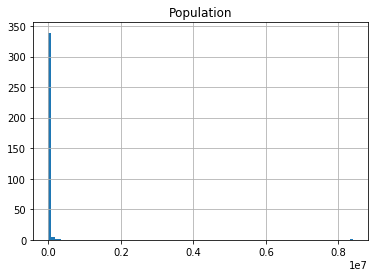

Median  7233.5
Std  450037.3675209857
Outliers above  907308.2350419714


In [10]:
# Check for outliers, central tendencies.
df_fbi['Population'].hist(bins=100)
plt.title('Population')
plt.show()

median = df_fbi.Population.median()
std = df_fbi.Population.std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)

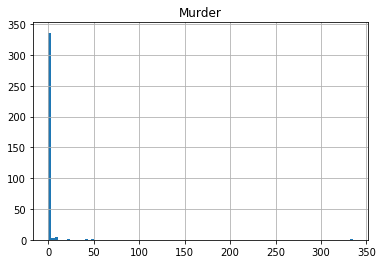

Median  0.0
Std  18.303672792887753
Outliers above  36.607345585775505


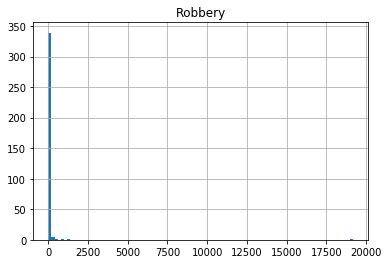

Median  1.0
Std  1031.0328732955247
Outliers above  2063.0657465910494


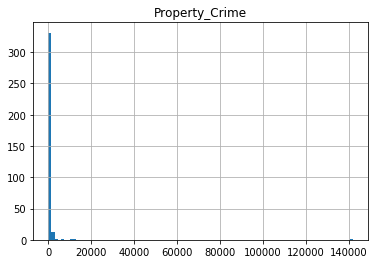

Median  112.5
Std  7659.724745633149
Outliers above  15431.949491266298


In [11]:
# Check for outliers, central tendencies for other variables.
df_fbi['Murder'].hist(bins=100)
plt.title('Murder')
plt.show()

median = df_fbi['Murder'].median()
std = df['Murder'].std()
mur_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', mur_out)

df['Robbery'].hist(bins=100)
plt.title('Robbery')
plt.show()

median = df_fbi['Robbery'].median()
std = df_fbi['Robbery'].std()
rob_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', rob_out)

df['Property_Crime'].hist(bins=100)
plt.title('Property_Crime')
plt.show()

median = df_fbi['Property_Crime'].median()
std = df_fbi['Property_Crime'].std()
prop_crime_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', prop_crime_out)

In [12]:
# Dealing with outliers (create a ceiling value for outliers).
df_fbi['Population'] = df_fbi['Population'].map(lambda x: x if x < pop_out else 900000)
df_fbi['Murder'] = df_fbi['Murder'].map(lambda x: x if x < mur_out else 36)
df_fbi['Robbery'] = df_fbi['Robbery'].map(lambda x: x if x < rob_out else 2000)
df_fbi['Property_Crime'] = df_fbi['Property_Crime'].map(lambda x: x if x < prop_crime_out else 15000)

In [13]:
# Create boolean values for 'Murder' and 'Total_Robbery' columns.
def is_zero(number):
    value = convert_number(number)
    
    if value==0:
        return 0
    else:
        return 1
df_fbi['Murder_bool'] = df_fbi['Murder'].apply(lambda x: is_zero(x))
df_fbi['Robbery_bool'] = df_fbi['Robbery'].apply(lambda x: is_zero(x))
df_fbi.head()

,City,Population,Population^2,Murder,Robbery,Property_Crime,Murder_bool,Robbery_bool
0,Adams Village,1861.000,3463321.000,0.000,0.000,12.000,0,0
1,Addison Town and Village,2577.000,6640929.000,0.000,0.000,24.000,0,0
2,Akron Village,2846.000,8099716.000,0.000,0.000,16.000,0,0
3,Albany,97956.000,9595377936.000,8.000,227.000,4090.000,1,1
4,Albion Village,6388.000,40806544.000,0.000,4.000,223.000,0,1


In [14]:
# Replace 'Robbery' and 'Property_Crime' columns with boolean value columns.
df_fbi2 = df_fbi[['City', 'Population', 'Population^2', 'Property_Crime', 'Murder_bool', 'Robbery_bool']]
df_fbi2.head()

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool
0,Adams Village,1861.000,3463321.000,12.000,0,0
1,Addison Town and Village,2577.000,6640929.000,24.000,0,0
2,Akron Village,2846.000,8099716.000,16.000,0,0
3,Albany,97956.000,9595377936.000,4090.000,1,1
4,Albion Village,6388.000,40806544.000,223.000,0,1


In [15]:
df_fbi.loc[216]

City                       New York
Population               900000.000
Population^2     70494931807876.000
Murder                       36.000
Robbery                    2000.000
Property_Crime            15000.000
Murder_bool                       1
Robbery_bool                      1
Name: 216, dtype: object

In [16]:
# Fill na values with zero.
df_fbi2.fillna(0)
# Show null column counts.
null_columns=df_fbi2.columns[df_fbi2.isnull().any()]
df_fbi2[null_columns].isnull().sum()

Population^2    3
dtype: int64

In [17]:
# View last columns to find missing na values.
df_fbi2.tail()

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool
346,Yonkers,199134.000,39654349956.000,2368.000,1,1
347,Yorktown Town,36643.000,1342709449.000,334.000,0,1
348,1 The figures shown in this column for the off...,900000.000,nan,15000.000,1,1
349,2 The figures shown in this column for the off...,900000.000,nan,15000.000,1,1
350,3 The FBI does not publish arson data unless i...,900000.000,nan,15000.000,1,1


In [18]:
# Eliminate the last three lines of the dataframe.
df_fbi3 = df_fbi2[:348]
df_fbi3.tail()

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool
343,Woodbury Town,10685.000,114169225.000,541.000,0,1
344,Woodridge Village,829.000,687241.000,17.000,0,0
345,Woodstock Town,5931.000,35176761.000,58.000,0,0
346,Yonkers,199134.000,39654349956.000,2368.000,1,1
347,Yorktown Town,36643.000,1342709449.000,334.000,0,1


In [19]:
# Find max population value and drop it.
df_fbi.groupby(['City','Population'])['Population'].max

<bound method GroupBy.max of <pandas.core.groupby.groupby.SeriesGroupBy object at 0x11ea6ceb8>>

In [20]:
# Double check value at row 216.
df_fbi.loc[216]

City                       New York
Population               900000.000
Population^2     70494931807876.000
Murder                       36.000
Robbery                    2000.000
Property_Crime            15000.000
Murder_bool                       1
Robbery_bool                      1
Name: 216, dtype: object

In [21]:
# Check for remaining null values.
null_columns=df_fbi3.columns[df_fbi3.isnull().any()]
df_fbi3[null_columns].isnull().sum()

Series([], dtype: float64)

In [22]:
# Check data types again.
print(df_fbi3.dtypes)

City               object
Population        float64
Population^2      float64
Property_Crime    float64
Murder_bool         int64
Robbery_bool        int64
dtype: object


In [23]:
# Find where Population is null as 0.
df_fbi3[df_fbi3['Population']==0]

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool


In [24]:
# Find where Population values are 0.
df_fbi3[df_fbi3['Population'].isnull()].index.tolist()

[]

In [25]:
# Check values for NYC.
df_fbi3[df_fbi3['City']=='New York']

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool
216,New York,900000.000,70494931807876.000,15000.000,1,1


In [26]:
# Run regression.
regr = linear_model.LinearRegression()
Y = df_fbi3['Property_Crime'].values.reshape(-1, 1)
X = df_fbi3[['Population', 'Population^2', 'Murder_bool', 'Robbery_bool']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('R-squared: \n', regr.score(X, Y))

Coefficients: 
 [[ 3.44157767e-02 -2.23888124e-10  1.43562879e+01 -9.44786464e+01]]
Intercept: 
 [-108.54935591]
R-squared: 
 0.8658812863422005


In [28]:
# Test the model with different holdout groups.
from sklearn.model_selection import train_test_split
# Create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_train, y_train)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))

With 20% Holdout: 0.8472102359190959
Testing on Sample: 0.8658812863422005


In [29]:
# Check my model using cross validation.
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X, Y, cv=10)

array([ 7.60446395e-01,  8.26604190e-01,  1.27024059e-03,  5.10759159e-01,
        4.79569542e-01,  4.26480578e-01, -3.05389647e+05,  8.24306289e-01,
        8.87043776e-01, -1.00389931e+00])

In [30]:
# Upload and show dataset.
df84 = pd.read_csv('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.csv', skiprows=3, header=1)
df84.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Adams Village,"1,851",0,0.000,NaN,0.000,0,0,11,1,10,0,0.000,nan
1,Addison Town and Village,"2,568",2,0.000,NaN,0.000,1,1,49,1,47,1,0.000,nan
2,Afton Village4,820,0,0.000,0,nan,0,0,1,0,1,0,0.000,nan
3,Akron Village,"2,842",1,0.000,NaN,0.000,0,1,17,0,17,0,0.000,nan
4,Albany4,"98,595",802,8.000,54,nan,237,503,"3,888",683,"3,083",122,12.000,nan


In [31]:
# Change long column names.
df84.rename(columns={"Murder and\nnonnegligent\nmanslaughter":"Murder"})

,City,Population,Violent crime,Murder,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Adams Village,"1,851",0,0.000,NaN,0.000,0,0,11,1,10,0,0.000,nan
1,Addison Town and Village,"2,568",2,0.000,NaN,0.000,1,1,49,1,47,1,0.000,nan
2,Afton Village4,820,0,0.000,0,nan,0,0,1,0,1,0,0.000,nan
3,Akron Village,"2,842",1,0.000,NaN,0.000,0,1,17,0,17,0,0.000,nan
4,Albany4,"98,595",802,8.000,54,nan,237,503,"3,888",683,"3,083",122,12.000,nan
5,Albion Village4,"5,872",26,0.000,3,nan,2,21,204,41,159,4,0.000,nan
6,Alexandria Bay Village4,"1,107",0,0.000,0,nan,0,0,7,2,5,0,0.000,nan
7,Alfred Village4,"4,032",11,1.000,1,nan,0,9,30,6,24,0,0.000,nan
8,Altamont Village4,"1,723",1,0.000,0,nan,0,1,2,2,0,0,0.000,nan
9,Amherst Town4,"118,860",128,1.000,16,nan,43,68,"2,066",176,"1,846",44,2.000,nan


In [32]:
# Show null column counts.
null_columns=df84.columns[df84.isnull().any()]
df84[null_columns].isnull().sum()

City                                        1
Population                                  7
Violent\ncrime                              7
Murder and\nnonnegligent\nmanslaughter      7
Rape\n(revised\ndefinition)1              149
Rape\n(legacy\ndefinition)2               234
Robbery                                     7
Aggravated\nassault                         7
Property\ncrime                             8
Burglary                                    7
Larceny-\ntheft                             8
Motor\nvehicle\ntheft                       7
Arson3                                     11
Unnamed: 13                               376
dtype: int64

In [33]:
# Eliminate commas from numbers > 999.
def convert_number(number):
    try:
        converted = float(number.replace(',', ''))
    except:
        converted = number
        
    return converted

In [34]:
# Change NaN values to 0. Convert object types to floats.
df84.dropna()
df84['Population'] = df84['Population'].apply(lambda x: convert_number(x))
df84['Population^2'] = df84['Population']**2
df84['Murder'] = df84['Murder and\nnonnegligent\nmanslaughter'].apply(lambda x: convert_number(x))
df84['Robbery'] = df84['Robbery'].apply(lambda x: convert_number(x))
df84['Property_Crime'] = df84['Property\ncrime'].apply(lambda x: convert_number(x))

In [35]:
# Create new data frame with only relevant columns.
df84_fbi = df84[['City', 'Population', 'Population^2', 'Murder', 'Robbery', 'Property_Crime']]

In [36]:
# Preview new data frame.
df84_fbi.head()

,City,Population,Population^2,Murder,Robbery,Property_Crime
0,Adams Village,1851.000,3426201.000,0.000,0.000,11.000
1,Addison Town and Village,2568.000,6594624.000,0.000,1.000,49.000
2,Afton Village4,820.000,672400.000,0.000,0.000,1.000
3,Akron Village,2842.000,8076964.000,0.000,0.000,17.000
4,Albany4,98595.000,9720974025.000,8.000,237.000,3888.000


In [37]:
# See central tendency data.
df84_fbi.describe()

,Population,Population^2,Murder,Robbery,Property_Crime
count,369.000,369.000,369.000,369.000,368.000
mean,37814.824,195523845923.664,1.453,60.661,698.361
std,441159.058,3738110713430.990,17.694,866.481,7123.614
min,79.000,6241.000,0.000,0.000,0.000
25%,2631.000,6922161.000,0.000,0.000,25.000
50%,6581.000,43309561.000,0.000,1.000,76.000
75%,15408.000,237406464.000,0.000,4.000,271.500
max,8473938.000,71807625227844.000,333.000,16581.000,135747.000


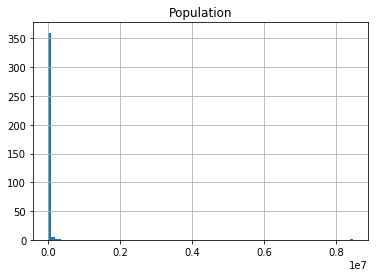

Median  6581.0
Std  441159.05754769867
Outliers above  888899.1150953973


In [38]:
# Check for outliers, central tendencies.
df84_fbi['Population'].hist(bins=100)
plt.title('Population')
plt.show()

median = df84_fbi.Population.median()
std = df84_fbi.Population.std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)

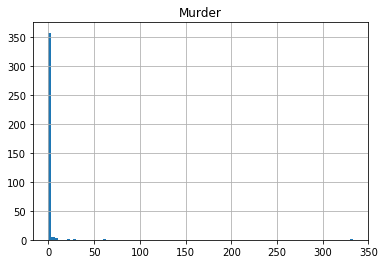

Median  0.0
Std  17.693911693485116
Outliers above  35.38782338697023


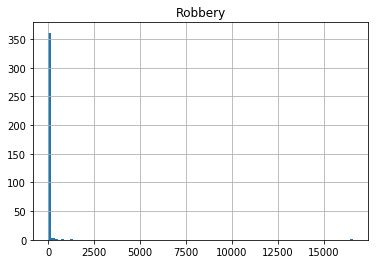

Median  1.0
Std  866.4808646119423
Outliers above  1733.9617292238845


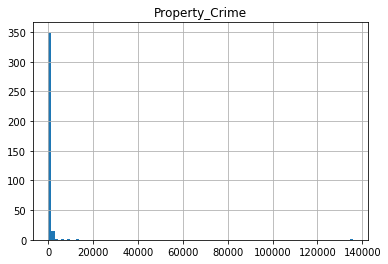

Median  76.0
Std  7123.613876533472
Outliers above  14323.227753066943


In [39]:
# Check for outliers, central tendencies for other variables.
df84_fbi['Murder'].hist(bins=100)
plt.title('Murder')
plt.show()

median = df84_fbi['Murder'].median()
std = df84['Murder'].std()
mur_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', mur_out)

df84['Robbery'].hist(bins=100)
plt.title('Robbery')
plt.show()

median = df84_fbi['Robbery'].median()
std = df84_fbi['Robbery'].std()
rob_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', rob_out)

df84['Property_Crime'].hist(bins=100)
plt.title('Property_Crime')
plt.show()

median = df84_fbi['Property_Crime'].median()
std = df84_fbi['Property_Crime'].std()
prop_crime_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', prop_crime_out)

In [40]:
# Dealing with outliers (create a ceiling value for outliers).
df84_fbi['Population'] = df84_fbi['Population'].map(lambda x: x if x < pop_out else 888900)
df84_fbi['Murder'] = df84_fbi['Murder'].map(lambda x: x if x < mur_out else 35)
df84_fbi['Robbery'] = df84_fbi['Robbery'].map(lambda x: x if x < rob_out else 1730)
df84_fbi['Property_Crime'] = df84_fbi['Property_Crime'].map(lambda x: x if x < prop_crime_out else 14325)

In [41]:
# Create boolean values for 'Murder' and 'Total_Robbery' columns.
def is_zero(number):
    value = convert_number(number)
    
    if value==0:
        return 0
    else:
        return 1
df84_fbi['Murder_bool'] = df84_fbi['Murder'].apply(lambda x: is_zero(x))
df84_fbi['Robbery_bool'] = df84_fbi['Robbery'].apply(lambda x: is_zero(x))
df84_fbi.head()

,City,Population,Population^2,Murder,Robbery,Property_Crime,Murder_bool,Robbery_bool
0,Adams Village,1851.000,3426201.000,0.000,0.000,11.000,0,0
1,Addison Town and Village,2568.000,6594624.000,0.000,1.000,49.000,0,1
2,Afton Village4,820.000,672400.000,0.000,0.000,1.000,0,0
3,Akron Village,2842.000,8076964.000,0.000,0.000,17.000,0,0
4,Albany4,98595.000,9720974025.000,8.000,237.000,3888.000,1,1


In [42]:
# Replace 'Robbery' and 'Property_Crime' columns with boolean value columns.
df84_fbi2 = df84_fbi[['City', 'Population', 'Population^2', 'Property_Crime', 'Murder_bool', 'Robbery_bool']]
df84_fbi2.head()

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool
0,Adams Village,1851.000,3426201.000,11.000,0,0
1,Addison Town and Village,2568.000,6594624.000,49.000,0,1
2,Afton Village4,820.000,672400.000,1.000,0,0
3,Akron Village,2842.000,8076964.000,17.000,0,0
4,Albany4,98595.000,9720974025.000,3888.000,1,1


In [43]:
# Fill na values with zero.
df84_fbi2.fillna(0)
# Show null column counts.
null_columns=df84_fbi2.columns[df84_fbi2.isnull().any()]
df84_fbi2[null_columns].isnull().sum()

City            1
Population^2    7
dtype: int64

In [44]:
# View last columns to find missing na values.
df84_fbi2.tail(10)

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool
366,Yonkers4,200624.000,40249989376.000,2009.000,1,1
367,Yorktown Town4,36989.000,1368186121.000,209.000,0,0
368,Youngstown Village4,1896.000,3594816.000,1.000,0,0
369,1 The figures shown in this column for the off...,888900.000,nan,14325.000,1,1
370,2 The figures shown in this column for the off...,888900.000,nan,14325.000,1,1
371,3 The FBI does not publish arson data unless i...,888900.000,nan,14325.000,1,1
372,4 This agency began the year submitting rape d...,888900.000,nan,14325.000,1,1
373,5 The FBI determined that the agency's data we...,888900.000,nan,14325.000,1,1
374,NaN,888900.000,nan,14325.000,1,1
375,,888900.000,nan,14325.000,1,1


In [45]:
# Eliminate the last three lines of the dataframe.
df84_fbi3 = df84_fbi2[:369]
df84_fbi3.tail(10)

,City,Population,Population^2,Property_Crime,Murder_bool,Robbery_bool
359,White Plains4,58103.000,3375958609.000,1046.000,1,1
360,Whitesboro Village,3727.000,13890529.000,41.000,0,1
361,Whitestown Town,9307.000,86620249.000,71.000,0,0
362,Windham Town4,1682.000,2829124.000,18.000,0,0
363,Wolcott Village,1646.000,2709316.000,4.000,0,0
364,"Woodbury Town4, 5",10739.000,115326121.000,14325.000,0,1
365,Woodstock Town4,5907.000,34892649.000,43.000,0,1
366,Yonkers4,200624.000,40249989376.000,2009.000,1,1
367,Yorktown Town4,36989.000,1368186121.000,209.000,0,0
368,Youngstown Village4,1896.000,3594816.000,1.000,0,0


In [46]:
# Find max population value and drop it.
df84_fbi.groupby(['City','Population'])['Population'].max

<bound method GroupBy.max of <pandas.core.groupby.groupby.SeriesGroupBy object at 0x11e80f898>>

In [47]:
# Check for remaining null values.
null_columns=df84_fbi3.columns[df84_fbi3.isnull().any()]
df84_fbi3[null_columns].isnull().sum()

Series([], dtype: float64)

In [48]:
# Run regression.
regr = linear_model.LinearRegression()
Y = df84_fbi3['Property_Crime'].values.reshape(-1, 1)
X = df84_fbi3[['Population', 'Population^2', 'Murder_bool', 'Robbery_bool']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('R-squared: \n', regr.score(X, Y))

Coefficients: 
 [[ 3.20246572e-02 -1.94652693e-10 -5.36213123e+01 -1.50050018e+01]]
Intercept: 
 [-93.04533485]
R-squared: 
 0.6223992294796541


In [50]:
# Test the model with different holdout groups.
from sklearn.model_selection import train_test_split
# Create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_train, y_train)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))

With 20% Holdout: 0.6303113378182882
Testing on Sample: 0.6223992294796541


In [51]:
# Check my model using cross validation.
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X, Y, cv=10)

array([ 7.85364435e-01,  7.62469399e-01,  3.99641542e-01,  5.26796590e-01,
        5.13215515e-01, -1.78430804e-01, -3.98665036e+05,  8.48521482e-01,
        8.78302177e-01, -1.54011720e-01])